# 1.0 - An analysis and prediction of the 2022 world cup

In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy.stats import poisson
import warnings 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%config InteractiveShell.ast_node_interactivity = 'all'

In [2]:
dict_table = pickle.load(open('dict_table','rb'))
df_historical_data = pd.read_csv('clean_fifa_worldcup_matches.csv')
df_fixture = pd.read_csv('clean_fifa_worldcup_fixture.csv')

After Loading in the cleaned data scraped off wikipedia, I split the dataset into two groups. A historic group and a group containing the past 3 world cup results.

In [3]:
df_historical_data_old_players = df_historical_data.loc[(df_historical_data['Year'] <= 2006)]
df_historical_data_active_players = df_historical_data.loc[(df_historical_data['Year'] >= 2010)]


Unlike the model by PyCoach, I split the model in the historical data (old) and the recent data (active) where I took into consideration that top football players usually have a career for about 14-16 years, allowing them to play 3 world cups in good circumstances. So the form of a team 3 world cups ago can still have an effect on the prediction for the next world cup. I made the cut at the 2010 world cup to adjust for recent form.

In [4]:
# Splitting the the database by matches played as home team and matches played as away team.
df_home_old = df_historical_data_old_players[['HomeTeam', 'HomeGoals', 'AwayGoals']]
df_away_old = df_historical_data_old_players[['AwayTeam', 'HomeGoals', 'AwayGoals']]
df_home_active = df_historical_data_active_players[['HomeTeam', 'HomeGoals', 'AwayGoals']]
df_away_active = df_historical_data_active_players[['AwayTeam', 'HomeGoals', 'AwayGoals']]

# Renaming the columns to make the table more readable.
df_home_old = df_home_old.rename(columns={'HomeTeam': 'Team', 'HomeGoals': 'GoalsScored', 'AwayGoals': 'GoalsConceded'})
df_away_old = df_home_old.rename(columns={'AwayTeam': 'Team', 'HomeGoals': 'GoalsConceded', 'AwayGoals': 'GoalsScored'})
df_home_active = df_home_active.rename(columns={'HomeTeam': 'Team', 'HomeGoals': 'GoalsScored', 'AwayGoals': 'GoalsConceded'})
df_away_active = df_home_active.rename(columns={'AwayTeam': 'Team', 'HomeGoals': 'GoalsConceded', 'AwayGoals': 'GoalsScored'})


# 1.1 - Analysis of the results of past and recent form.

In order to have a look at the gained results, I first add the goals scored as the home team and the goals scored as the away team, then take the mean value in order to obtain the average goals scored per match. Similarly this is done for the goals conceded.

After that, I wanted to see how much different the results of the 3 most recent world cups have been compared to the historic results, so I subtracted the historic results with the recent results and presented the results in a table.

Then I made a second table where I pick out a few teams that I want to highlight for some additional analysis

In [5]:
def highlight_bottom_row(s, target_index, border_thickness="4px", border_color="black"):
    if s.name == target_index:
        return [f'border-top: {border_thickness} solid {border_color};'] * len(s)
    else:
        return [''] * len(s)

# concat df_home and df_away, group by team and calculate the mean
df_team_strength_old = pd.concat([df_home_old, df_away_old], ignore_index=True).groupby('Team').mean()
df_team_strength_active = pd.concat([df_home_active, df_away_active], ignore_index=True).groupby('Team').mean()


#Comparing the historic results with the recent results and taking the mean to show the change in results
df_team_strength_comparison = (df_team_strength_old - df_team_strength_active) * (-1)
df_team_strength_comparison = df_team_strength_comparison.dropna()
df_team_strength_comparison = df_team_strength_comparison[(df_team_strength_comparison['GoalsScored']!=0) & (df_team_strength_comparison['GoalsConceded']!=0)]

df_team_strength_comparison = pd.concat([df_team_strength_comparison, df_team_strength_comparison.mean().to_frame().T])
df_team_strength_comparison.rename(index={0:'Average Change'},inplace=True)

df_team_strength_comparison.style.apply(highlight_bottom_row, target_index='Average Change', axis=1).background_gradient(subset=['GoalsScored'], cmap="RdYlGn", vmin=-2, vmax=2).background_gradient(subset=['GoalsConceded'], cmap="RdYlGn_r", vmin=-2,vmax=2)


teams_of_interest = df_team_strength_comparison.loc[['Netherlands','Belgium', 'Croatia', 'Portugal', 'Colombia', 'Saudi Arabia', 'Greece', 'Argentina']]

df_teams_of_interest_comparison = pd.concat([teams_of_interest])
df_teams_of_interest_comparison.style.background_gradient(subset=['GoalsScored'], cmap="RdYlGn", vmin=-2, vmax=2).background_gradient(subset=['GoalsConceded'], cmap="RdYlGn_r", vmin=-2,vmax=2)

,GoalsScored,GoalsConceded
Algeria,-0.500000,-1.000000
Argentina,-0.620833,0.287500
Belgium,1.104762,-0.276190
Brazil,-0.688963,0.645485
Cameroon,-0.500000,1.250000
Chile,-0.083333,0.250000
Colombia,1.133333,-0.866667
Costa Rica,-0.916667,-1.333333
Croatia,0.500000,-0.250000
Denmark,-1.333333,-0.333333


,GoalsScored,GoalsConceded
Netherlands,-0.514620,-0.397661
Belgium,1.104762,-0.276190
Croatia,0.500000,-0.250000
Portugal,0.523077,-0.123077
Colombia,1.133333,-0.866667
Saudi Arabia,1.500000,-1.166667
Greece,1.333333,-0.666667
Argentina,-0.620833,0.287500


First I calculate the average goals scored for both historic and recent results. Then I made a dataframe showing how much their recent form changed their results compared to their historic results. This can be seen in the table above. Negative Goals Conceded means that the team conceded less goals, which makes them stronger. Hence the negative values being represented with green color. To produce this table, I compared the historic results with the recent results by subtracting the two, getting rid of NaN results as they represent cases where a subtraction wasn't possible, and removed the cases where zero change was spotted. I then highlighted a few countries that were of interest to me in the second table.

By looking at the Average change, we can easily see that scoring goals in modern times seems much more difficult, which is in line with the more defensive oriented playstyle a lot of teams adopted starting from 2014. This playstyle notably gained fame as Van Gaal got third place with the Netherlands using a much more defensive lineup in spite of having one of the best forwards at the time. As a result, we see their GoalsScored drop, but also their GoalsConceded drop (see second table). In spite of the lower amount of goals scored, his results were very notable, sparking a rush of more defensive formations in the following years. 

Other than the netherlands, it is interesting to point out that there are 5 teams with significantly better results: Belgium, Colombia, Croatia, Greece, Portugal, Saudi Arabia.
The reason for these recent successes can be traced back to key elements. 

1. Belgium experienced a golden generation starting from 2012, which is shortly before I made the recent form cut. Their team has been exceptional ever since 2014 so it is only natural to see this reflected in their recent form stats.
   
2. Croatia and Portugal are in the same boat as they both gained access to one of the best players their country has ever seen. Luka Modric and Christiano Ronaldo both turned out players who can carry a mediocre team on their back and elevate the level of their team, as well as inspiring the next generation. As a result, Portugal and Croatia are now considered subtop that regularly reach top level football even in the present where the direct impact of these two star players have declined. Naturally the stats of these two countries are much stronger in recent results as opposed to their historic stats.

3. Colombia who haven't qualified for many world cups, also had a boost in strength with their new roster, starring a player that later became the top scorer of Colombia in world cups of all time. The 2014 roster actually managed to make it to quarter finals, displaying a huge increase in quality.


4. Then there is greece, which is a bit of an odd-ball. There is no real reason why their results have significantly improved over recent times. It seems like this is just a generational fluke, and I expect their results to drop off after this generation is over.

5. Saudi Arabia has been flooding money in their football league, doing whatever they can to attract the best players, coaches and staff, right as they are about to retire, in order to increase the interest in the sport. As a result, their own players get to experience a much higher level of play, and also benefit from beter education, coaching and equipment. Naturally, I expect their results to steadily improve over time.

6. Argentina is interesting. They are similar in Croatia, Columbia and Portugal in that they had a star player who's skill way exceeds their teams average, Messi. Yet when you compare their results, the stats are actually average. Similar to the rest of the world, their average goals scored dropped by half a goal per match. A plausible explanation for this is twofold. On one hand Messi has shown time and again that he's the type of player that can elevate a great team to absurd heights, but seems invisible in a poorly functioning team. On top of that, it's not like Argentina was historically bad and Messi had an opportunity to improve their results like colombia, belgium and crotia. Instead, argentina was always a strong contender for finals, being present in 6 world cup finals over 22 world cups, and winning 3 of them. This ranks them as the 4th country in the world when it comes to reaching world cups. As a result, it's difficult to improve on results when you're already among the best teams. It is then only natural that Argentina follows the average trend as the comparisons are with their own past results, not compared to other teams. 

## Adding weight to the recent form and historic results. Strengthening the recent form and Weakening the impact of the historic results.

For the continuation of this analysis/prediction, I have added weights to the database as Recent form is much more impactful than historic results. So I made their recent results twice as impactful in this prediction.

On top of that, I worsened the results of teams that have a history but no recent results, in order to weaken their effect in the prediction as their form is clearly out of shape since they couldn't qualify 3 world cups in a row.


In [6]:
for team, row in df_team_strength_old.iterrows():
    if team in df_team_strength_active.index:
        df_team_strength_old.at[team, 'GoalsScored'] = (df_team_strength_old.at[team, 'GoalsScored'] + 2 * df_team_strength_active.at[team, 'GoalsScored'])/3
        df_team_strength_old.at[team, 'GoalsConceded'] = (df_team_strength_old.at[team, 'GoalsConceded'] + 2 * df_team_strength_active.at[team, 'GoalsConceded'])/3
    else:
        df_team_strength_old.at[team, 'GoalsScored'] = df_team_strength_old.at[team, 'GoalsScored'] / 2
        df_team_strength_old.at[team, 'GoalsConceded'] = df_team_strength_old.at[team, 'GoalsConceded'] * 2
        
for team, row in df_team_strength_active.iterrows():
    if team not in df_team_strength_old.index:
        df_team_strength_active.at[team, 'GoalsScored'] = df_team_strength_active.at[team, 'GoalsScored']
        df_team_strength_active.at[team, 'GoalsConceded'] = df_team_strength_active.at[team, 'GoalsConceded']
        df_team_strength_old = pd.concat([df_team_strength_old, df_team_strength_active.loc[[team]]])

df_team_strength = df_team_strength_old

# 2. Adding a Poisson distribution function to make predictions regarding the world cup results.

Following @ThePyCoach's tutorial, I used his distribution function to calculate the probability of a team winning in a specific matchup. However, I noticed that in order to calculate the lamba, he multiplied the goalsscored with the away team's goals conceded. I feel this is not accurate at all because it would imply that if for example, the Netherlands face off against Germany and the Netherlands score on average 2 goals, and Germany concedes on average 0 goals. We would expect the Netherlands to score somewhere between 0 and 2 goals in this matchup, as Germany's defense is strong enough to concede on average 0 goals, but netherlands have the ability to score 2 goals on average. In @ThePyCoach's version however, the moment a team has 0 average scored or conceded, the goals scored for that match are by definition 0. Also, if both values are above 1, they would ramp up the goals scored. Therefor I think it's much more appropriate to take the average between the expected goal (home team) and conceded goal (away team) as this always lies in between the two values.

Other than that, I added in the creation of bar charts with appropriate coloring to highlight the most probable outcome for each matchup.

In [7]:
def predict_points(home, away, ax=None):
    if home in df_team_strength.index and away in df_team_strength.index:
        #goals_scored * goals conceded
        lamb_home = (df_team_strength.at[home, 'GoalsScored'] + df_team_strength.at[away,'GoalsConceded'])/2
        lamb_away = (df_team_strength.at[away, 'GoalsScored'] + df_team_strength.at[home,'GoalsConceded'])/2
        prob_home, prob_away, prob_draw = 0,0,0
        for x in range(0,11): 
            for y in range(0,11):
                p = poisson.pmf(x, lamb_home) * poisson.pmf(y, lamb_away)
                if x == y:
                    prob_draw += p
                elif x > y:
                    prob_home += p
                else:
                    prob_away+= p        
        points_home = 3 * prob_home + prob_draw
        points_away = 3 * prob_away + prob_draw
        
        plot_labels = [f'{home} \n{prob_home.round(3)}', f'Draw\n{prob_draw.round(3)}',f'{away}\n{prob_away.round(3)}'] 
        plot_values = [prob_home, prob_draw, prob_away]
        
        if ax != None:
            if prob_home > prob_draw and prob_home > prob_away and prob_draw > prob_away:
                ax.bar(plot_labels, plot_values, color = ['tab:green', 'tab:orange', 'tab:red'])
            elif prob_home > prob_draw and prob_home > prob_away and prob_away > prob_draw:
                ax.bar(plot_labels, plot_values, color = ['tab:green', 'tab:red', 'tab:orange'])
            elif prob_draw > prob_home and prob_draw > prob_away and prob_home > prob_away:
                ax.bar(plot_labels, plot_values, color = ['tab:orange', 'tab:green', 'tab:red'])
            elif prob_draw > prob_home and prob_draw > prob_away and prob_away > prob_home:
                ax.bar(plot_labels, plot_values, color = ['tab:red', 'tab:green', 'tab:orange'])
            elif prob_away > prob_home and prob_away > prob_draw and prob_home > prob_draw:
                ax.bar(plot_labels, plot_values, color = ['tab:orange', 'tab:red', 'tab:green'])
            else:
                ax.bar(plot_labels, plot_values, color = ['tab:red', 'tab:orange', 'tab:green'])
            ax.set(ylabel='Probability of occuring', title=f'{home} vs {away}')
        return (points_home, points_away)
    else:
        return (0, 0)

# 3. Predicting the World Cup 2022

## 3.1 Group Stage

In [8]:
# Splitting the fixtures into group, knockout, quarter, semi and final

df_fixture_group_48 = df_fixture[:48].copy()
df_fixture_knockout = df_fixture[48:56].copy()
df_fixture_quarter = df_fixture[56:60].copy()
df_fixture_semi = df_fixture[60:62].copy()
df_fixture_final = df_fixture[62:].copy()

For each group we calculate the matches that are being played within that group. Each group has 4 teams and they play each other once.
This results in 6 matches per group except for the group with qatar as there was no data on qatar beforehand. Then for each match, the predicted score is compared


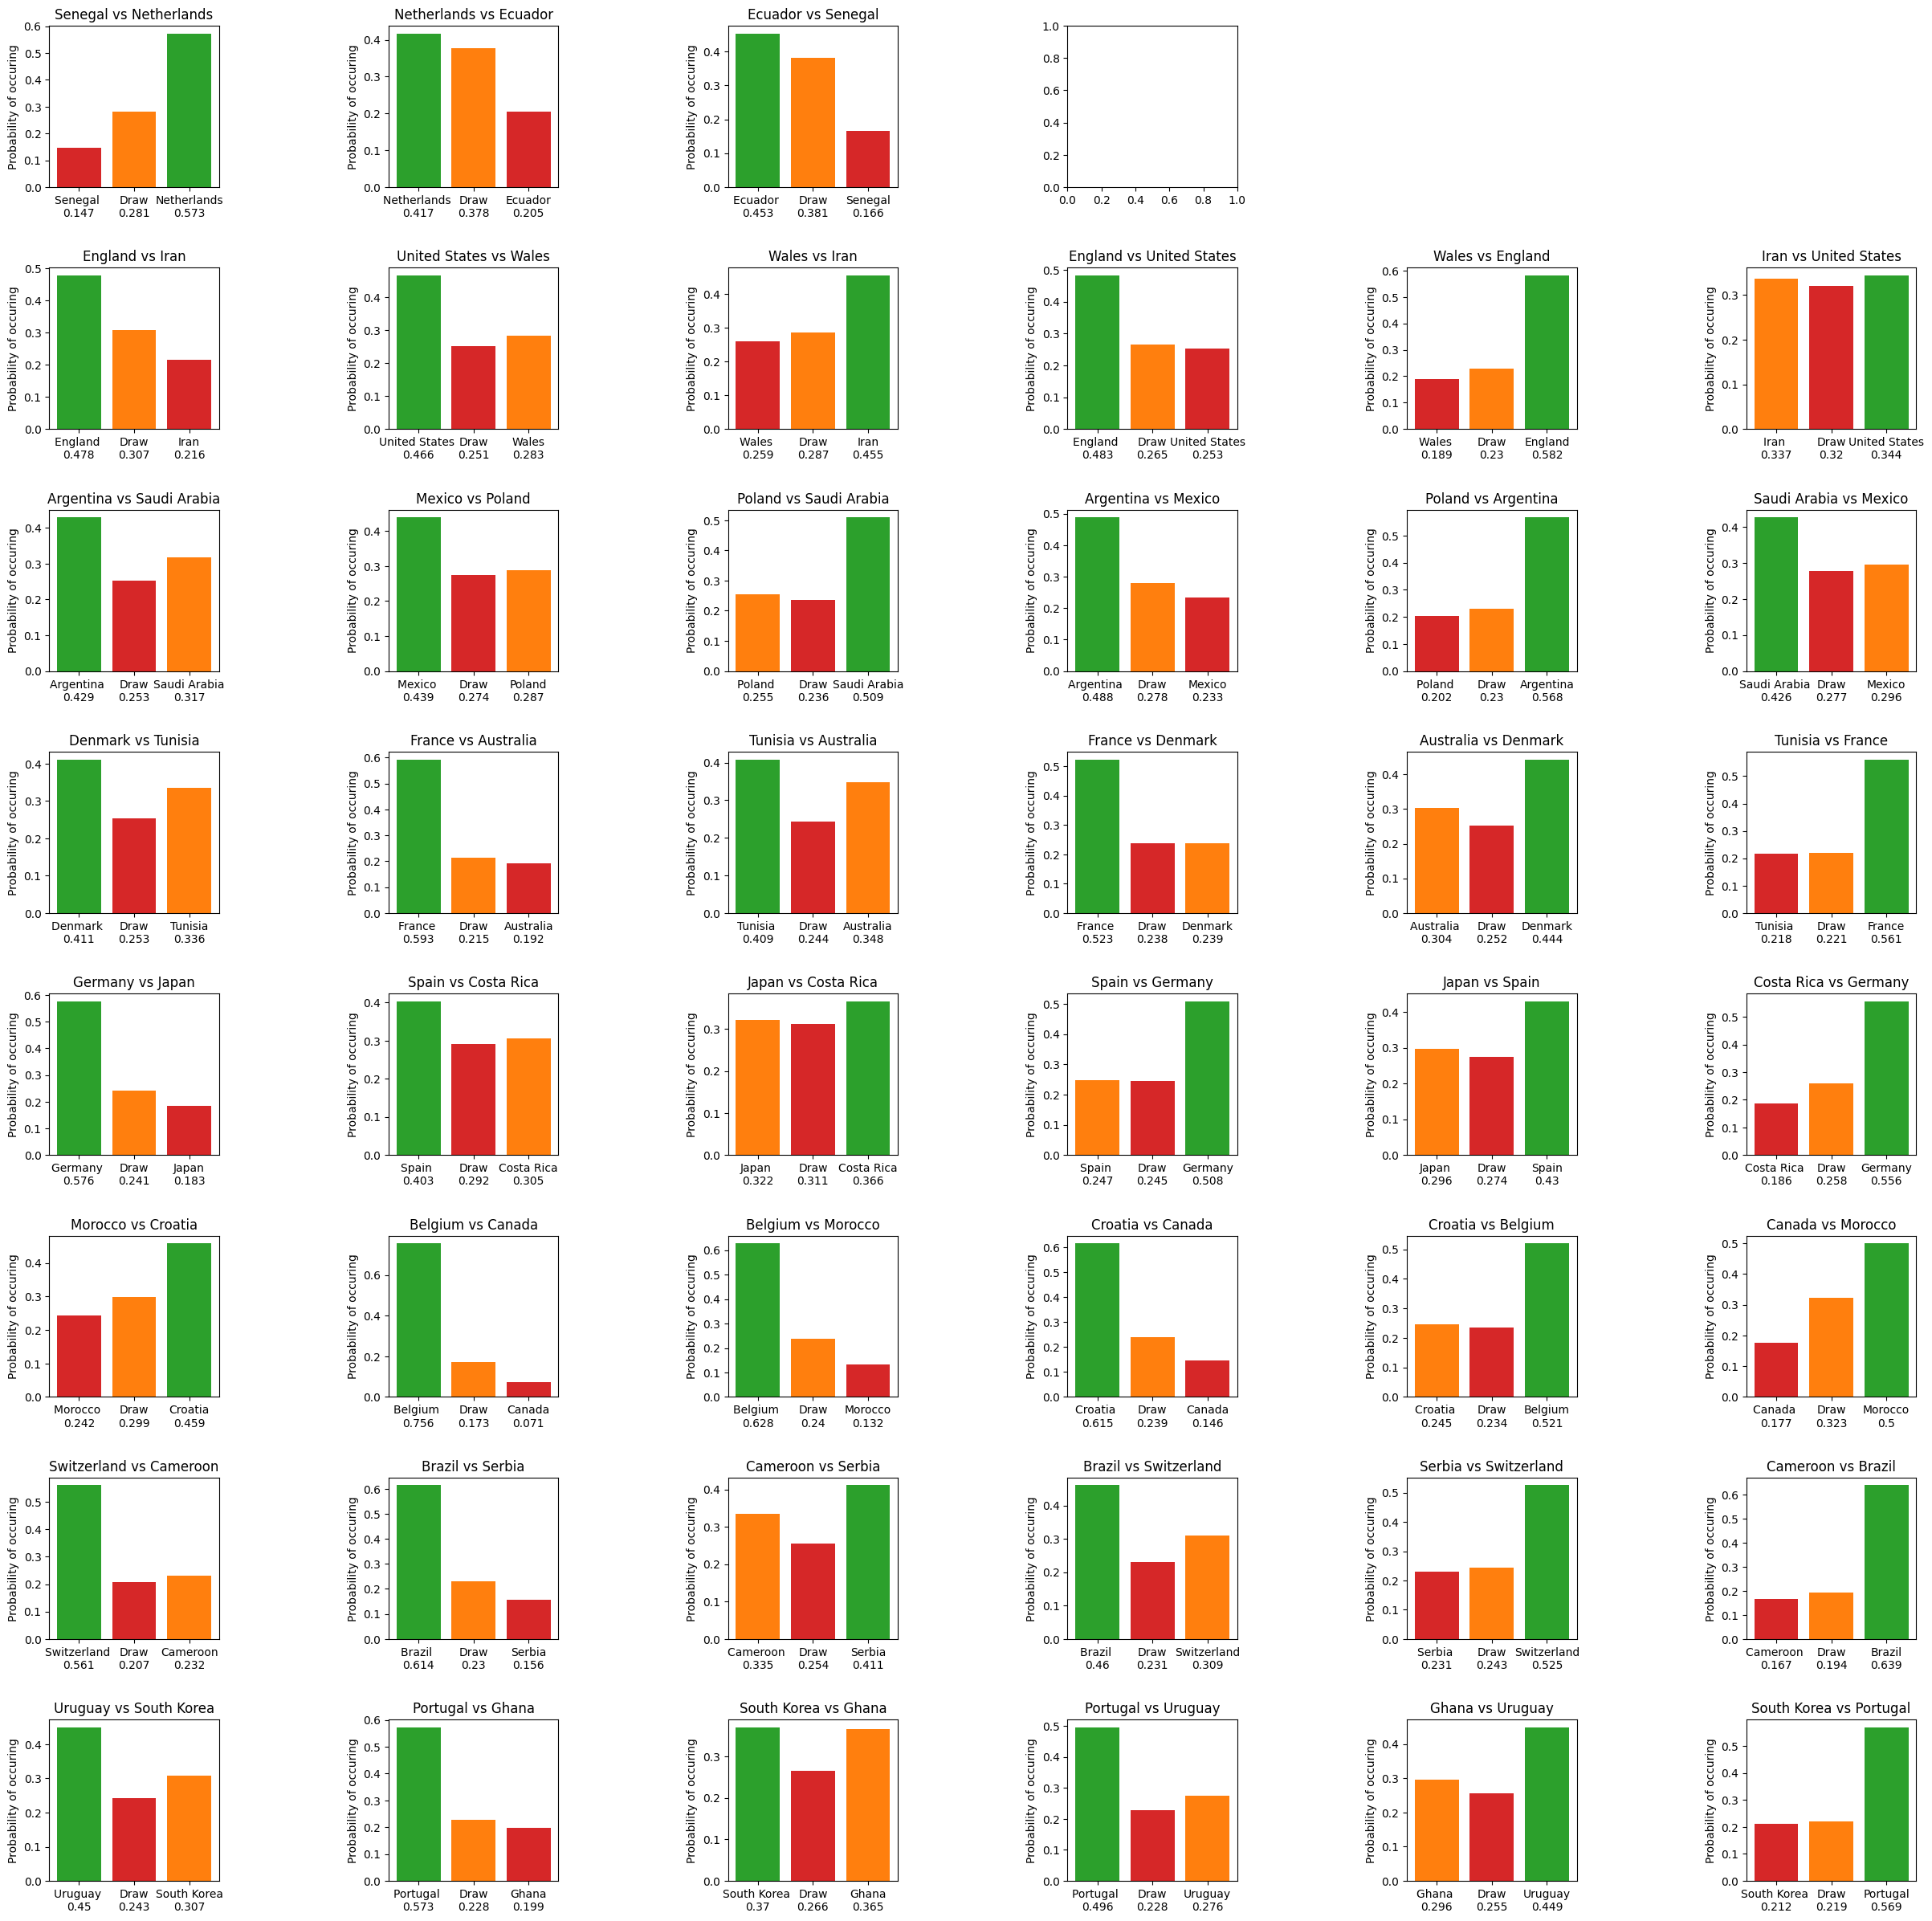

Group A:


,First place,Second place,Third place,Fourth place
Team,Netherlands,Ecuador,Senegal,Qatar (H)
Pts,4.0,3.0,2.0,0.0




Group B:


,First place,Second place,Third place,Fourth place
Team,England,United States,Iran,Wales
Pts,5.0,4.0,4.0,3.0




Group C:


,First place,Second place,Third place,Fourth place
Team,Argentina,Saudi Arabia,Mexico,Poland
Pts,5.0,5.0,4.0,3.0




Group D:


,First place,Second place,Third place,Fourth place
Team,France,Denmark,Tunisia,Australia
Pts,6.0,4.0,4.0,3.0




Group E:


,First place,Second place,Third place,Fourth place
Team,Germany,Spain,Costa Rica,Japan
Pts,6.0,4.0,3.0,3.0




Group F:


,First place,Second place,Third place,Fourth place
Team,Belgium,Croatia,Morocco,Canada
Pts,6.0,5.0,3.0,2.0




Group G:


,First place,Second place,Third place,Fourth place
Team,Brazil,Switzerland,Serbia,Cameroon
Pts,6.0,5.0,3.0,3.0




Group H:


,First place,Second place,Third place,Fourth place
Team,Portugal,Uruguay,South Korea,Ghana
Pts,6.0,4.0,3.0,3.0


In [9]:
print("For each group we calculate the matches that are being played within that group. Each group has 4 teams and they play each other once.")
print("This results in 6 matches per group except for the group with qatar as there was no data on qatar beforehand. Then for each match, the predicted score is compared")

warnings.filterwarnings('ignore') 
fig = plt.figure(figsize =([30, 30]))
gs = gridspec.GridSpec(8, 6, height_ratios = [4,4,4,4,4,4,4,4], width_ratios = [2,2,2,2,2,2], wspace = 1, hspace=0.5)
plot_names = []
for i in range(0,48):
    plot_name = "ax"+str(i)
    plot_names.append(plot_name)

plot_index = 0
plot_row = 0
plot_column = 0
for group in dict_table:
    teams_in_group = dict_table[group]['Team'].values
    df_fixture_group_6 = df_fixture_group_48[df_fixture_group_48['home'].isin(teams_in_group)]
    for index, row in df_fixture_group_6.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away, plt.subplot(gs[plot_row,plot_column]))
        dict_table[group].loc[dict_table[group]['Team'] == home, 'Pts'] += points_home
        dict_table[group].loc[dict_table[group]['Team'] == away, 'Pts'] += points_away
        plot_index += 1
        plot_column += 1
    plot_column = 0
    plot_row += 1
    dict_table[group] = dict_table[group].sort_values('Pts', ascending=False).reset_index()
    dict_table[group] = dict_table[group][['Team', 'Pts']]
    dict_table[group] = dict_table[group].round(0)
plt.tight_layout()
plt.show()


for name, df in dict_table.items():
    df.index = ['First place', 'Second place', 'Third place', 'Fourth place']
    print(f"\033[1m{name}:\033[0m")
    display(df.T)
    print("\n")

In [10]:
# We then take the number 1 and number 2 of each group and place them in the fixture for the knockout phase.

for group in dict_table:
    group_winner = dict_table[group].loc['First place', 'Team']
    runner_up = dict_table[group].loc['Second place', 'Team']

    df_fixture_knockout.replace({f'Winners {group}': group_winner, 
                                 f'Runners-up {group}': runner_up}, inplace=True)

df_fixture_knockout['winner'] = '?'
df_fixture_knockout['loser'] = '?'
df_fixture_knockout

,home,score,away,year,winner,loser
48,Netherlands,Match 49,United States,2022,?,?
49,Argentina,Match 50,Denmark,2022,?,?
50,France,Match 52,Saudi Arabia,2022,?,?
51,England,Match 51,Ecuador,2022,?,?
52,Germany,Match 53,Croatia,2022,?,?
53,Brazil,Match 54,Uruguay,2022,?,?
54,Belgium,Match 55,Spain,2022,?,?
55,Portugal,Match 56,Switzerland,2022,?,?


In [11]:
# Now we calculate who has the higher amount of predicted points and store them as winner, making the other team the loser.
def highlight(x):
    g = 'lightgreen'
    r = 'pink'

    m1 = x['winner'] == x['home']
    m2 = x['loser'] == x['home']
    m3 = x['winner'] == x['away']
    m4 = x['loser'] == x['away']
    m5 = x['winner']
    m6 = x['loser']
    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    
    df1['home'] = np.where(m1, 'background-color: {}'.format(g), df1['home'])
    df1['home'] = np.where(m2, 'background-color: {}'.format(r), df1['home'])
    df1['away'] = np.where(m3, 'background-color: {}'.format(g), df1['away'])
    df1['away'] = np.where(m4, 'background-color: {}'.format(r), df1['away'])
    df1['winner'] = np.where(m5, 'background-color: {}'.format(g), df1['winner'])
    df1['loser'] = np.where(m6, 'background-color: {}'.format(r), df1['loser'])
    return df1

def highlight_winner(x):
    g = 'gold'
    s = 'silver'
    b = 'darkorange'
    
    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    
    if x.loc[63,'home'] == x.loc[63,'winner']:
        df1.loc[63,'home'] = 'background-color: {}'.format(g)
        df1.loc[63,'away'] = 'background-color: {}'.format(s)
        print("haha")
    if x.loc[63,'home'] == x.loc[63,'loser']:
        df1.loc[63,'away'] = 'background-color: {}'.format(g)
        df1.loc[63,'home'] = 'background-color: {}'.format(s)

    if x.loc[62,'home'] == x.loc[62,'winner']:
        df1.loc[62,'home'] = 'background-color: {}'.format(b)
        df1.loc[62,'away'] = 'background-color: '
    if x.loc[62,'away'] == x.loc[62,'winner']:
        df1.loc[62,'away'] = 'background-color: {}'.format(b)
        df1.loc[62,'home'] = 'background-color: '
    return df1

    
def get_winner(df_fixture_updated):
    for index, row in df_fixture_updated.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away)

        if points_home > points_away:
            winner = home
            loser = away
        else:
            winner = away
            loser = home
        df_fixture_updated.loc[index, 'winner'] = winner
        df_fixture_updated.loc[index, 'loser'] = loser
    return df_fixture_updated

In [12]:
new_df = get_winner(df_fixture_knockout)
new_df.style.apply(highlight, axis=None)

,home,score,away,year,winner,loser
48,Netherlands,Match 49,United States,2022,Netherlands,United States
49,Argentina,Match 50,Denmark,2022,Argentina,Denmark
50,France,Match 52,Saudi Arabia,2022,France,Saudi Arabia
51,England,Match 51,Ecuador,2022,England,Ecuador
52,Germany,Match 53,Croatia,2022,Germany,Croatia
53,Brazil,Match 54,Uruguay,2022,Brazil,Uruguay
54,Belgium,Match 55,Spain,2022,Belgium,Spain
55,Portugal,Match 56,Switzerland,2022,Portugal,Switzerland


In [13]:
#we have to update the table and switch from one fixture to the next as the knockout phase is now played. 

def updated_table(df_fixture_round_1, df_fixture_round_2):
    for index, row in df_fixture_round_1.iterrows():
        winner = df_fixture_round_1.loc[index, 'winner']
        loser = df_fixture_round_1.loc[index, 'loser']
        match = df_fixture_round_1.loc[index, 'score']
        df_fixture_round_2.replace({f'Winners {match}':winner}, inplace=True)
        df_fixture_round_2.replace({f'Losers {match}':loser}, inplace=True)
    df_fixture_round_2['winner'] = '?'
    df_fixture_round_2['loser'] = '?'
    return df_fixture_round_2

In [14]:
updated_table(df_fixture_knockout, df_fixture_quarter).style.set_properties(subset=["winner"], background="lightgreen").set_properties(subset=["loser"], background="pink")

,home,score,away,year,winner,loser
56,Germany,Match 58,Brazil,2022,?,?
57,Netherlands,Match 57,Argentina,2022,?,?
58,Belgium,Match 60,Portugal,2022,?,?
59,England,Match 59,France,2022,?,?


In [15]:
new_df = get_winner(df_fixture_quarter)
new_df.style.apply(highlight, axis=None)

,home,score,away,year,winner,loser
56,Germany,Match 58,Brazil,2022,Germany,Brazil
57,Netherlands,Match 57,Argentina,2022,Netherlands,Argentina
58,Belgium,Match 60,Portugal,2022,Portugal,Belgium
59,England,Match 59,France,2022,France,England


In [16]:
updated_table(df_fixture_quarter, df_fixture_semi).style.set_properties(subset=["winner"], background="lightgreen").set_properties(subset=["loser"], background="pink")

,home,score,away,year,winner,loser
60,Netherlands,Match 61,Germany,2022,?,?
61,France,Match 62,Portugal,2022,?,?


In [17]:
new_df = get_winner(df_fixture_semi)
new_df.style.apply(highlight, axis=None)

,home,score,away,year,winner,loser
60,Netherlands,Match 61,Germany,2022,Germany,Netherlands
61,France,Match 62,Portugal,2022,Portugal,France


In [18]:
updated_table(df_fixture_semi, df_fixture_final).style.set_properties(subset=["winner"], background="lightgreen").set_properties(subset=["loser"], background="pink")

,home,score,away,year,winner,loser
62,Netherlands,Match 63,France,2022,?,?
63,Germany,Match 64,Portugal,2022,?,?


In [19]:
df_final_results = get_winner(df_fixture_final)

In [20]:
df_final_results.style.apply(highlight_winner, axis=None)

,home,score,away,year,winner,loser
62,Netherlands,Match 63,France,2022,France,Netherlands
63,Germany,Match 64,Portugal,2022,Portugal,Germany


In [21]:
print(f"The winner is {df_final_results.loc[63,'winner']}, the runner up is {df_final_results.loc[63, 'loser']} and the third place will go to {df_final_results.loc[62, 'winner']}")

The winner is Portugal, the runner up is Germany and the third place will go to France


So with our updated model implementing a stronger weight to the more recent results, it's actually Portugal that shows its face, with Germany being second and France taking away that bronze third. Interestingly, both Brazil and England have dropped out in the quarter finals.

## What happened to Brazil and England

Brazil, which is and always has been a powerhouse in football, somehow doesn't make it out of the Quarter finals in this predictive model. How come?

We gain a little bit more insight if we compare the strength of their past 3 world cups as opposed to the historical ones:


In [22]:
# First we reload the original strength before weighing the recent form twice as heavy. Then we check the goals in history and recently.

df_team_strength_old = pd.concat([df_home_old, df_away_old], ignore_index=True).groupby('Team').mean()
df_team_strength_active = pd.concat([df_home_active, df_away_active], ignore_index=True).groupby('Team').mean()

In [23]:
#Here we show the historial stats for brazil:
print("Brazil old:")
df_team_strength_old.loc[['Brazil']]
print("\n Brazil recent:")
df_team_strength_active.loc[['Brazil']]

df_diff_brazil = df_team_strength_active.loc[['Brazil']] - df_team_strength_old.loc[['Brazil']]
df_diff_brazil

print("Brazil old:")
df_team_strength_old.loc[['Brazil']]
print("\n Brazil recent:")
df_team_strength_active.loc[['Brazil']]

df_diff_brazil = df_team_strength_active.loc[['Brazil']] - df_team_strength_old.loc[['Brazil']]
df_diff_brazil

Brazil old:


,GoalsScored,GoalsConceded
Team,,
Brazil,2.304348,0.73913



 Brazil recent:


,GoalsScored,GoalsConceded
Team,,
Brazil,1.615385,1.384615


,GoalsScored,GoalsConceded
Team,,
Brazil,-0.688963,0.645485


Brazil old:


,GoalsScored,GoalsConceded
Team,,
Brazil,2.304348,0.73913



 Brazil recent:


,GoalsScored,GoalsConceded
Team,,
Brazil,1.615385,1.384615


,GoalsScored,GoalsConceded
Team,,
Brazil,-0.688963,0.645485


As we can see, Brazil actually had a really rough streak recently. In fact, the entirety of football was starting to focus more on defense rather than offense and top teams would focus more on winning with 1 goal rather than scoring the typical 3 to finish a game. In spite of this, Brazil continued to focus on a more offensive playstyle which simply wasn't effective anymore. As a result they ended up conceding many more goals by not adapting to the new defensive way of playing while also scoring less goals against weaker opponents as they too got much better at defending.

This took a height in the world cup of 2014, where Brazil lost 1-7 against germany and 0-3 against The netherlands. 

In [24]:
df_evaulate_change_of_form = pd.concat([df_team_strength_old, df_team_strength_active], axis=1, join='inner')
print("\nHere I took the mean value of the GoalsScored and the mean value of GoalsConceded to show that indeed teams became more skilled at defense")
df_evaulate_change_of_form.mean().to_frame().T
print("Next, we simply subtract old with the recent and look how much it has changed.")


Here I took the mean value of the GoalsScored and the mean value of GoalsConceded to show that indeed teams became more skilled at defense


,GoalsScored,GoalsConceded,GoalsScored,GoalsConceded
0,1.556423,1.250283,1.037138,1.263673


Next, we simply subtract old with the recent and look how much it has changed.


In [25]:
df_dropped_teams = pd.DataFrame()
for index,row in df_team_strength_active.iterrows():
    if index in df_team_strength_old.index:
        df_team_strength_active.at[index, 'GoalsScored'] = df_team_strength_old.at[index, 'GoalsScored'] - df_team_strength_active.at[index, 'GoalsScored']
        df_team_strength_active.at[index, 'GoalsConceded'] = df_team_strength_old.at[index, 'GoalsConceded'] - df_team_strength_active.at[index, 'GoalsConceded']
    else:
        df_dropped_teams = pd.concat([df_dropped_teams,row],axis=1)
        df_team_strength_active = df_team_strength_active.drop([index])

df_team_strength_active.mean()
print("As expected, the goals scored have dropped by 0.5 on average.")

GoalsScored      0.519285
GoalsConceded   -0.013390
dtype: float64

As expected, the goals scored have dropped by 0.5 on average.


In [26]:
df_dropped_teams.T.mean()

GoalsScored      1.119048
GoalsConceded    1.523810
dtype: float64